### Basic code to read easterly wave tracks by Lawton et al (2022) and plot a track that matches user specified tropical storm (if available in the track database)

- Lawton, Q. A., S. J. Majumdar, K. Dotterer, C. Thorncroft, and C. J. Schreck, 2022: The Influence of Convectively Coupled Kelvin Waves on African Easterly Waves in a Wave-Following Framework. Monthly Weather Review, 150(8), 2055-2072, https://doi.org/10.1175/MWR-D-21-0321.1.

#### Then, a track following IR loop is assembled and displayed 

- NCSU Tropical and Large Scale Dynamics
- A. Aiyyer


### Other finer scale datasets: 

https://user.eumetsat.int/catalogue

### **MERGEDIR:** 4km, half hourly 
https://disc.gsfc.nasa.gov/datasets/GPM_MERGIR_1/summary?keywords=MERGEDIR. 

OpenDAP format: https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2012/200/merg_2012071800_4km-pixel.nc4.dap.nc4

In [1]:
import numpy as np
import xarray as xr
from datetime import date, timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.animation as animation
# convert the animation to javascript for display
#plt.rcParams["animation.html"] = "jshtml"
import geocat.viz.util as gvutil
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
plt.rcParams['animation.embed_limit'] = 2**128
from metpy.plots import colortables

In [2]:
# get the easterly wave track data from https://zenodo.org/records/13350860

# location of the data on the local machine:
track_data_path = "/Users/bmapes/GitHub/SkySymphony/ERA5_AEW_TRACKS/"
file_prefix = "AEW_tracks_post_processed_year_"

In [3]:
# Select storm 
storm_Name = "DOLLY"
storm_Year = 2008

# Select storm
storm_Name = "IRMA"
storm_Year = 2017

# Select storm
#storm_Name = "ERNESTO"
#storm_Year = 2012

# Other good long-track ones, from the time-lon perusals 
# Ian 2022, Dolly 2014, Chantal 2013, Harvey 2011 parade? Fiona 2010 parade? Fred 2009 from 40E, 
# Dolly 2008, Ike 2008 parade, Dean 2007, Ernesto 2006, Frances 2005 parade?, 
# Grace 2003, Emily or Floyd 1999

In [4]:
fileName = track_data_path +  file_prefix + str(storm_Year) + '.nc'
ds = xr.open_dataset(fileName)
ds

<xarray.Dataset> Size: 3MB
Dimensions:         (latitude: 80, longitude: 180, time: 612, system: 66)
Coordinates:
  * latitude        (latitude) float64 640B 60.0 59.0 58.0 ... -17.0 -18.0 -19.0
  * longitude       (longitude) float64 1kB -120.0 -119.0 -118.0 ... 58.0 59.0
  * time            (time) datetime64[ns] 5kB 2017-06-01 ... 2017-10-31T18:00:00
  * system          (system) float64 528B 1.0 2.0 3.0 4.0 ... 64.0 65.0 66.0
Data variables:
    AEW_lon         (system, time) float64 323kB ...
    AEW_lat         (system, time) float64 323kB ...
    AEW_lon_smooth  (system, time) float64 323kB ...
    AEW_lat_smooth  (system, time) float64 323kB ...
    AEW_strength    (system, time) float64 323kB ...
    TC_gen_time     (system) datetime64[ns] 528B ...
    TC_name         (system) <U8 2kB ...
    curv_data_mean  (time, longitude) float64 881kB ...

In [5]:
lon = ds.AEW_lon
lat = ds.AEW_lat
n_waves = lon.shape[0]
print(n_waves)

66


In [6]:
idx = np.where(ds.TC_name == storm_Name)[0]

if idx.shape == (0,):
   print ("No storm match found")
else:
    istorm = idx[0]
    print(istorm, storm_Name)

39 IRMA


In [7]:
#locate a specific TC
lon_s = ds.AEW_lon_smooth.isel(system=istorm).dropna(dim='time')
lat_s =  ds.AEW_lat_smooth.isel(system=istorm).dropna(dim='time')

#locate the track index where the wave becomes a TC
TC_genesis_time = ds.TC_gen_time.isel(system=istorm)
idt = np.where(lat_s.time == TC_genesis_time)[0][0]
print("Storm genesis at ", idt, TC_genesis_time.values)

Storm genesis at  41 2017-08-30T00:00:00.000000000


In [8]:
# PLOT the track of the wave + TC

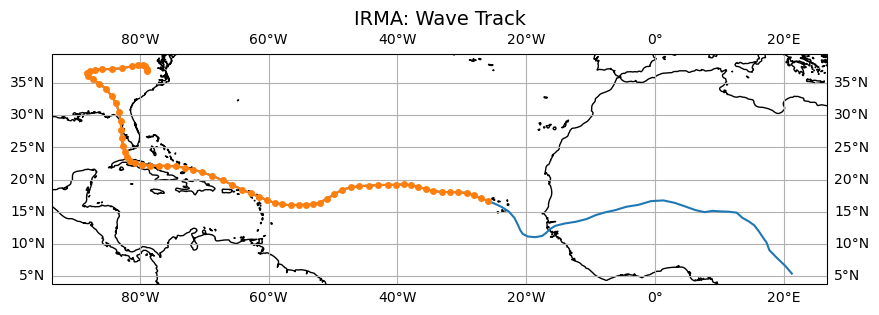

In [9]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()  # cylindrical equidistant

ax = fig.add_subplot(1, 1, 1, projection=proj)
# Add coastlines and gridlines
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot  wave track
ax.plot(lon_s, lat_s, marker='none', markersize=2, transform=ccrs.PlateCarree())
ax.plot(lon_s[idt:], lat_s[idt:], marker='o', markersize=4, transform=ccrs.PlateCarree())
plt.title(storm_Name + ": Wave Track", fontsize=14)
plt.show()

# download MERGE_IR half-hourly images, a centered box

In [ ]:
#------------------ Center and size (+/- deg) around the central point 
dlon = 20.
dlat = 15.
    
n6htimes = lon_s.size # 6h is the wave track time step 

dates=lon_s.time.values
date0 = pd.to_datetime(dates[0])

In [ ]:
# Loop from first time until last, files are hourly 
Images_per_6h = 6

# Get the times and interpolated center positions
ntimes = n6htimes*Images_per_6h   # equally spaced Timedelta(hours=1)

interpolated_lon = lon_s.interp(time=np.linspace(lon_s.time.values[0].astype('int64'), 
                                                 lon_s.time.values[-1].astype('int64'), 
                                                 lon_s.size * Images_per_6h).astype('datetime64[ns]'))
interpolated_lat = lat_s.interp(time=np.linspace(lat_s.time.values[0].astype('int64'), 
                                                 lat_s.time.values[-1].astype('int64'), 
                                                 lat_s.size * Images_per_6h).astype('datetime64[ns]'))

for i in range(ntimes):
    datePlot = date0 + i*pd.Timedelta(hours=1)
    
# if accessing from ncei
    #url_base = 'https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/' + YYYY + '/'

# MERGE_IR
    doy = datePlot.strftime('%Y%j')  # %j gives day of year with zero-padding
    year = datePlot.strftime('%Y')  # %Y gives year with zero-padding
    mm = datePlot.strftime('%m')  # %m gives month with zero-padding
    dd = datePlot.strftime('%d')  # %d gives day with zero-padding
    hh = datePlot.strftime('%H')  # %H gives hour with zero-padding
        
    filename = f"merg_{year}{mm}{dd}{hh}_4km-pixel.nc4"
    url = f"https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/{year}/{int(doy[4:]):03d}/{filename}"

    print(datePlot, url)

# Define center point for image at this time 
    centlon = interpolated_lon[i]; 
    centlat = interpolated_lat[i]; 

# sel() the box 
    ds = xr.open_dataset(url)
    LatIndexer, LonIndexer = 'lat', 'lon'
    dsbox = ds.sel(**{LatIndexer: slice(centlat-dlat, centlat+dlat),
                      LonIndexer: slice(centlon-dlon, centlon+dlon)})
# Write it out
    dsbox.to_netcdf('~/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/time'+str(i).zfill(3)+'.nc')   

# Enhanced color movie, thanks ChatGPT 

with some smoothing of the map jitters as each hourly file has two time levels

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from pathlib import Path
import os
from subprocess import run

# ==== USER CONFIG ====
data_folder = Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/")  # change this
frame_folder =Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames")
frame_folder.mkdir(exist_ok=True)
video_filename = "/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/"+"enhanced_ir.mp4"

vmin, vmax = 170, 300
dpi = 150
# =====================

frame_folder.mkdir(exist_ok=True)

# 1. Create enhanced IR colormap (cold to warm)
def create_enhanced_ir_colormap():

    color_points = [
        (170, "#000000"),  # black (coldest cloud tops)
        (180, "#800080"),  # purple
        (190, "#ff0000"),  # red
        (200, "#ff8000"),  # orange
        (210, "#ffff00"),  # yellow
        (220, "#00ff00"),  # green
        (235, "#00ffff"),  # cyan
        (240, "#0000ff"),  # blue (end of enhancement)
        (250, "#ffffff"),  # white (warmest)
        (270, "#dcdcdc"),  # light gray
        (285, "#a0a0a0"),  # mid gray
        (300, "#000000"),  # black surface

    ]
    temps, colors = zip(*color_points)
    normed = [(t - min(temps)) / (max(temps) - min(temps)) for t in temps]
    normed[0], normed[-1] = 0.0, 1.0
    return mcolors.LinearSegmentedColormap.from_list("enhanced_ir", list(zip(normed, colors)), N=256)

cmap = create_enhanced_ir_colormap()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Preload lat/lon grids from all files
nc_files = sorted(data_folder.glob("*.nc"))
grid_info = []
for file in nc_files:
    with xr.open_dataset(file) as ds:
        grid_info.append({
            "file": file,
            "lat": ds['lat'].load(),
            "lon": ds['lon'].load()
        })

# 3. Generate plots with smoothed coastline movement
frame_count = 0

for i, grid in enumerate(grid_info):
    ds = xr.open_dataset(grid['file'])
    Tb_all = ds['Tb']
    lat_now = grid['lat']
    lon_now = grid['lon']

    if i < len(grid_info) - 1:
        lat_next = grid_info[i+1]['lat']
        lon_next = grid_info[i+1]['lon']
    else:
        lat_next = lat_now
        lon_next = lon_now

    for t in range(Tb_all.sizes['time']):
        Tb = Tb_all.isel(time=t)
        timestamp = str(Tb_all.time.values[t])[:16].replace(":", "").replace("T", "_")

        # Smooth coastlines for 2nd timestep
        if t == 0:
            coast_lat = lat_now
            coast_lon = lon_now
        else:
            coast_lat = 0.5 * (lat_now + lat_next)
            coast_lon = 0.5 * (lon_now + lon_next)

        # Define extent from coast grid
        extent = [
            float(coast_lon.min()), float(coast_lon.max()),
            float(coast_lat.min()), float(coast_lat.max())
        ]

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        Tb.plot.imshow(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=True,
            cbar_kwargs={'label': 'Brightness Temperature [K]'}
        )

        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_title(f"Tb at {timestamp}", fontsize=12)
        plt.tight_layout()

        out_file = frame_folder / f"frame_{frame_count:04d}.png"
        plt.savefig(out_file, dpi=dpi)
        plt.close()
        print(f"Saved {out_file.name}")
        frame_count += 1

# 4. Create video using ffmpeg
ffmpeg_cmd = [
    "ffmpeg", "-y", "-framerate", "6",
    "-i", str(frame_folder / "frame_%04d.png"),
    "-c:v", "libx264", "-pix_fmt", "yuv420p",
    video_filename
]

print("Creating video...")
run(ffmpeg_cmd)
print(f"✅ Video saved as {video_filename}")
